# Data Reformatting


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle as pkl
import seaborn as sns
import os

In [ ]:
path = "D:/Maynooth Coursework/Final_Project/Simanova_Data/"

## Converting BrainVision Files to FIF

In [ ]:
for i in range(6, 28):
    try:
        # rename all files ending in .eeg.seg to .eeg
        os.rename(f"D:/Maynooth Coursework/Final_Project/Simanova_Data/Unformated/Plosone Simanova 2010/RawData_EEG/subj{i:02}.eeg.seg", 
                f"D:/Maynooth Coursework/Final_Project/Simanova_Data/Unformated/Plosone Simanova 2010/RawData_EEG/subj{i:02}.eeg");
    except:
        print("The file doesnt exist or renamed already:", f"subj{i:02}.eeg.seg", "to",f"subj{i:02}.eeg" );

    try:
        # rename all files ending in vmrk.vmrk to .vmrk
        os.rename(f"D:/Maynooth Coursework/Final_Project/Simanova_Data/Unformated/Plosone Simanova 2010/RawData_EEG/subj{i:02}.vmrk.vmkr", 
                f"D:/Maynooth Coursework/Final_Project/Simanova_Data/Unformated/Plosone Simanova 2010/RawData_EEG/subj{i:02}.vmrk");
    except:
        print("The file doesnt exist or renamed already:", f"subj{i:02}.vmrk.vmkr", "to",f"subj{i:02}.vmrk" );


In [ ]:
if not os.path.exists(path+"/reformatted-data"):
    os.mkdir(path+"/reformatted-data")
if not os.path.exists(path+"/reformatted-data/raw"):
    os.mkdir(path+"/reformatted-data/raw")

for i in range(6, 28):
    try: 
        # Read in data in original format
        raw = mne.io.read_raw_brainvision(f"D:/Maynooth Coursework/Final_Project/Simanova_Data/Unformated/Plosone Simanova 2010/RawData_EEG/subj{i:02}.vhdr", preload = True)

        # # Extract events from file annotations
        events, event_id = mne.events_from_annotations(raw)

        # # Create a new channel and add events to it
        info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
        stim_data = np.zeros((1, len(raw.times)))
        stim_raw = mne.io.RawArray(stim_data, info)
        raw.add_channels([stim_raw], force_update_info=True)
        raw.add_events(events, stim_channel='STI')

        # # Save the data as a raw MNE file
        raw.save(f"D:/Maynooth Coursework/Final_Project/Simanova_Data/reformatted-data/raw/subj{i:02}raw.fif", overwrite=True)

    except:
        print(f"Error reading subj{i:02}")

To test that the file conversion process worked correctly we can read in one of our new files and verify it's contents.

In [2]:
mne.io.read_raw_fif("D:/Maynooth Coursework/Final_Project/Simanova_Data/reformatted-data/raw/subj15raw.fif", preload = True)

Opening raw data file D:/Maynooth Coursework/Final_Project/Simanova_Data/reformatted-data/raw/subj15raw.fif...
    Range : 0 ... 2680509 =      0.000 ...  5361.018 secs
Ready.
Reading 0 ... 2680509  =      0.000 ...  5361.018 secs...


Measurement date,"April 21, 2009 14:21:55 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"64 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.02 Hz
Lowpass,200.00 Hz


## The Preprocessing steps are exhibitted for one subject

Opening raw data file D:/Maynooth Coursework/Final_Project/Simanova_Data/reformatted-data/raw/subj15raw.fif...
    Range : 0 ... 2680509 =      0.000 ...  5361.018 secs
Ready.
Reading 0 ... 2680509  =      0.000 ...  5361.018 secs...
Using matplotlib as 2D backend.


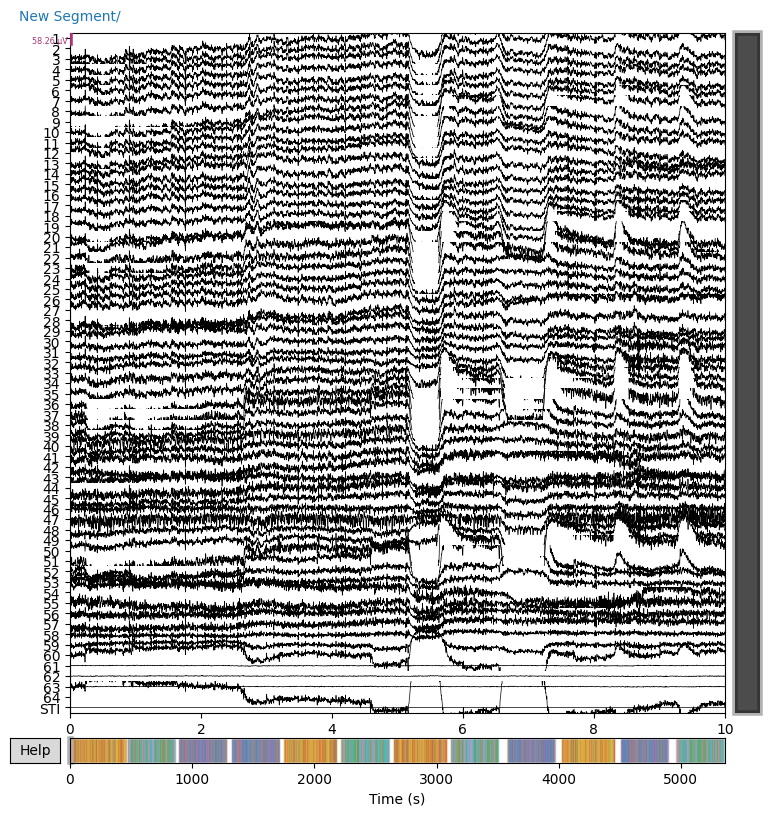

In [2]:
raw = mne.io.read_raw_fif("D:/Maynooth Coursework/Final_Project/Simanova_Data/reformatted-data/raw/subj15raw.fif", preload=True)

raw.plot(n_channels=100, scalings='auto', title='Raw Data', show=True, block=True);


## Preprocessing Steps

- Setting electrode locations
- Setting linked mastoids refrence
- Setting EOG channel
- Removing ocular artifacts using EOG channels and ICA
- Epoching data from 300ms before stimulus to 700ms after
- Applying bandpass filter (1-30 Hz)
- Removing trials with voltage variations at electrode $\geq 150 \mu V$ 





### Assigning the montage

In [3]:
# Set channel 64 to EOG 
raw.set_channel_types({'64': 'eog'})

# Drop channels 61,62,64
raw.drop_channels(['61', '62', '63'])

## Rename channel 59 to 60 and 60 to 61
raw.rename_channels({'60': '61', '59': '60', '64': '62'})


easycap_montage = mne.channels.make_standard_montage("easycap-M10")
raw.set_montage(easycap_montage)

Measurement date,"April 21, 2009 14:21:55 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,63 points
Good channels,"60 EEG, 1 EOG, 1 Stimulus"
Bad channels,None
EOG channels,62
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.02 Hz
Lowpass,200.00 Hz


EasyCap M-10 montage electrode map

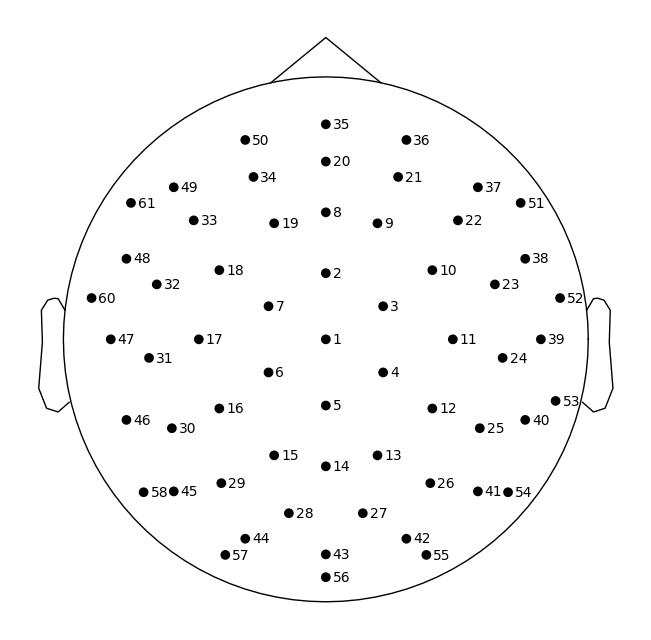

In [4]:
raw.plot_sensors(show_names=True);

Using EOG channel: 62
EOG channel index for this subject is: [60]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel 62 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 183 significant peaks
Number of EOG events detected: 183
Not setting metadata
183 matching events found
No baseline correction applied
Using data from preloaded Raw for 183 events and 501 original time points ...
0 bad epochs dropped
No projector specified for this

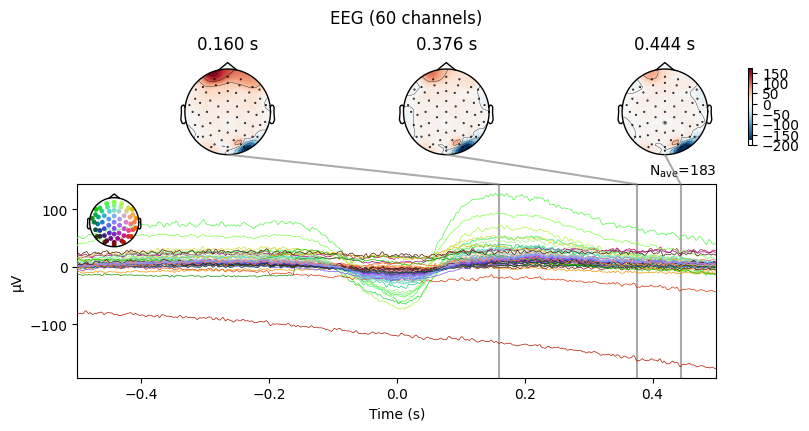

In [5]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
eog_evoked.plot_joint();

In [6]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=30.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


In [7]:
ica = mne.preprocessing.ICA(n_components=0.90, max_iter="auto", random_state=97)
ica.fit(filt_raw)

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 18.4s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (2680510 samples)
ICA components,5
Available PCA components,60
Channel types,eeg
ICA components marked for exclusion,—


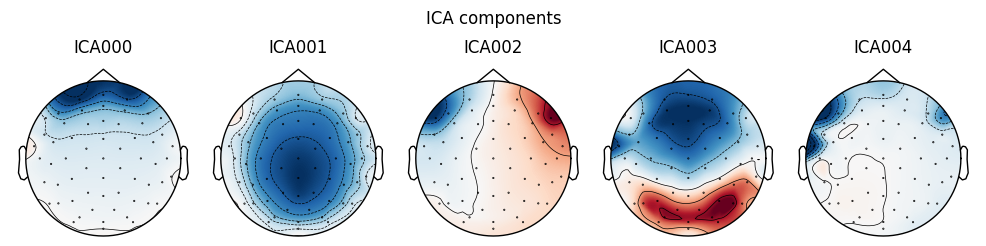

In [8]:
#ICA components
ica.plot_components();


Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components


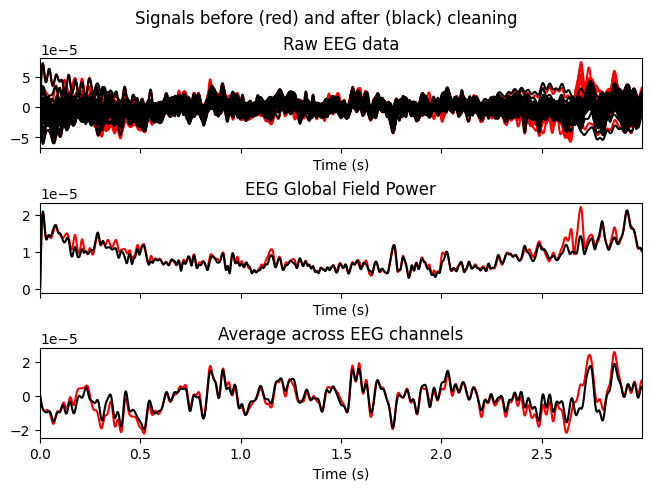

In [9]:
# Difference plots to showcase the noise that will be cleaned
ica.plot_overlay(filt_raw, exclude=[0], picks="eeg");

Using EOG channel: 62
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- F

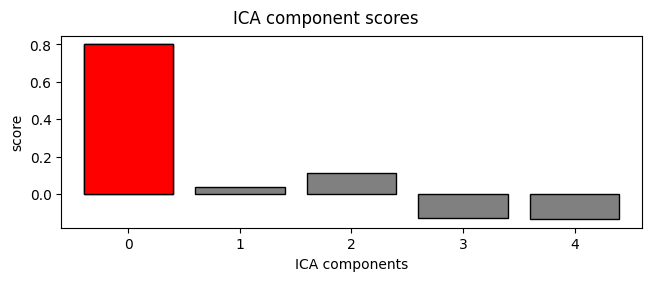

In [10]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(filt_raw, ch_name="62", threshold=1.8)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores);




#### ICA plot for Artifact detection (Unfiltered)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2680 matching events found
No baseline correction applied
0 projection items activated


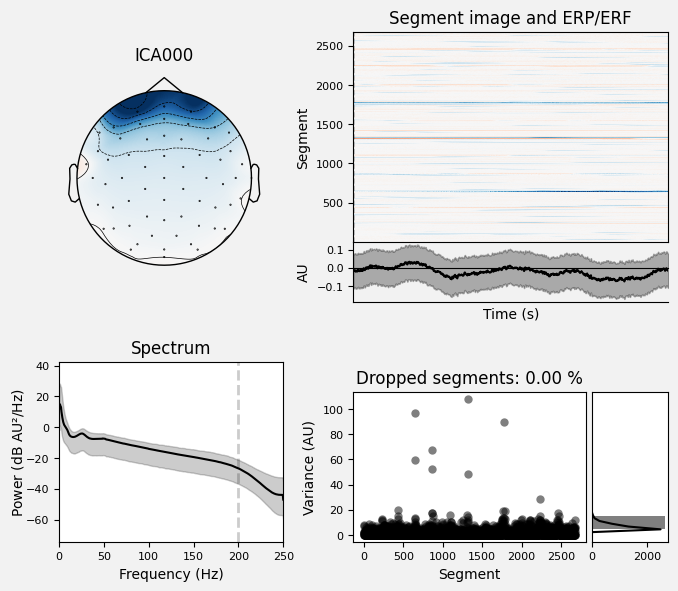

In [13]:
# plot diagnostics
ica.plot_properties(raw, picks=eog_indices);



#### Time Series of Independent Components and EOG channel for filtering

Creating RawArray with float64 data, n_channels=6, n_times=2680510
    Range : 0 ... 2680509 =      0.000 ...  5361.018 secs
Ready.


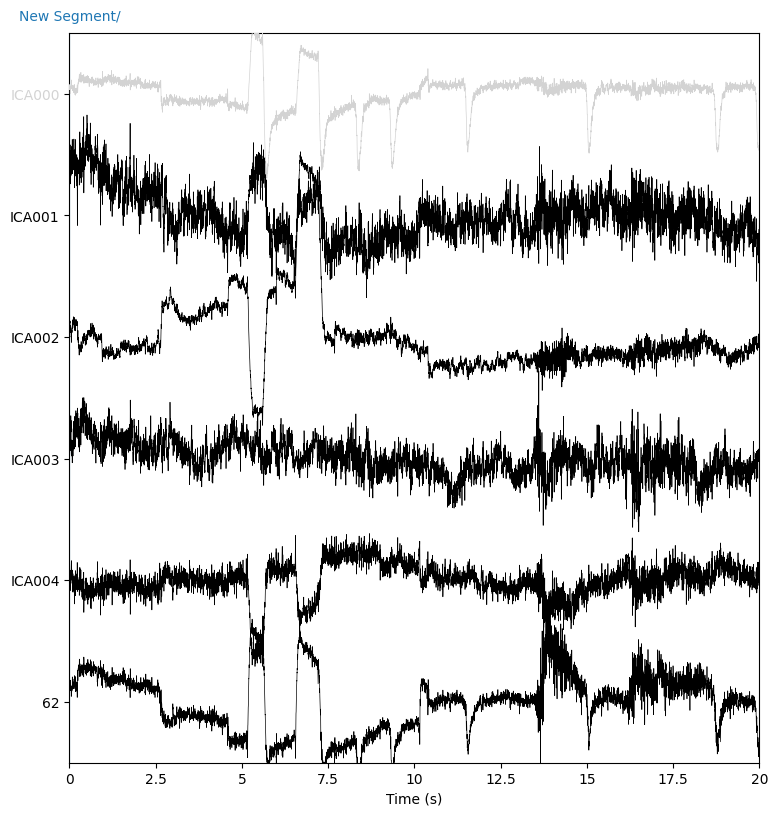

In [14]:
# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False);

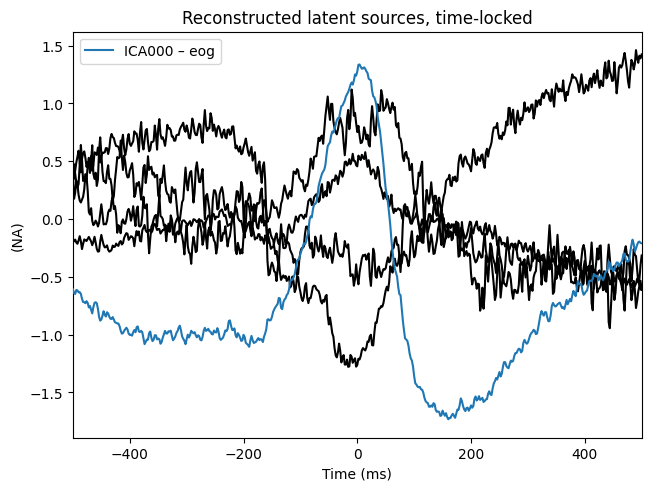

In [15]:
# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked);


Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components


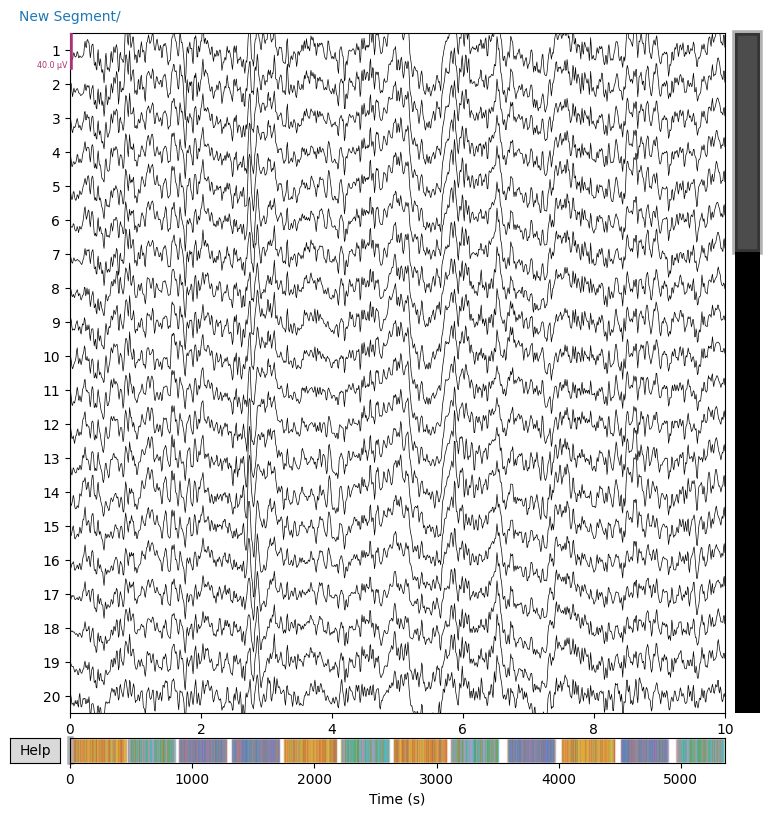

In [16]:
## Noise removal with ICA
raw = ica.apply(filt_raw)

## Plot of the filtered data
raw.plot();


#### ICA plot for Artifact detection (post Filtering)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2680 matching events found
No baseline correction applied
0 projection items activated


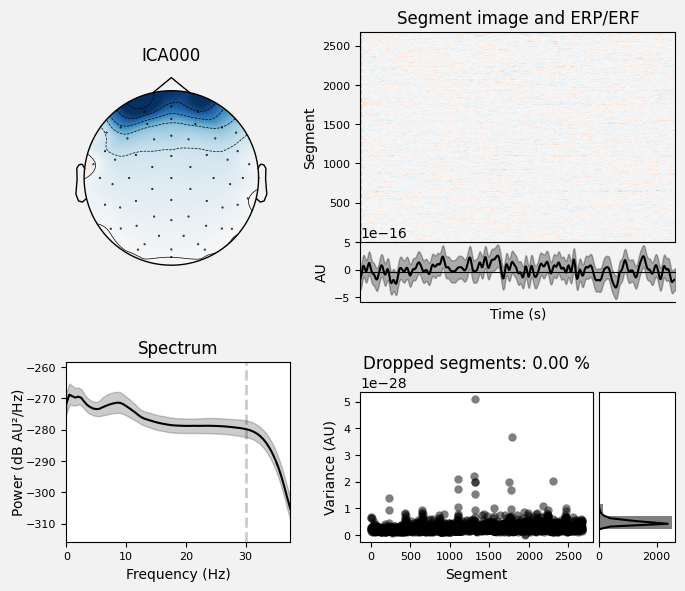

In [17]:
ica.plot_properties(raw, picks=eog_indices);


#### Time Series of Independent Components and EOG channel after filtering

Creating RawArray with float64 data, n_channels=6, n_times=2680510
    Range : 0 ... 2680509 =      0.000 ...  5361.018 secs
Ready.


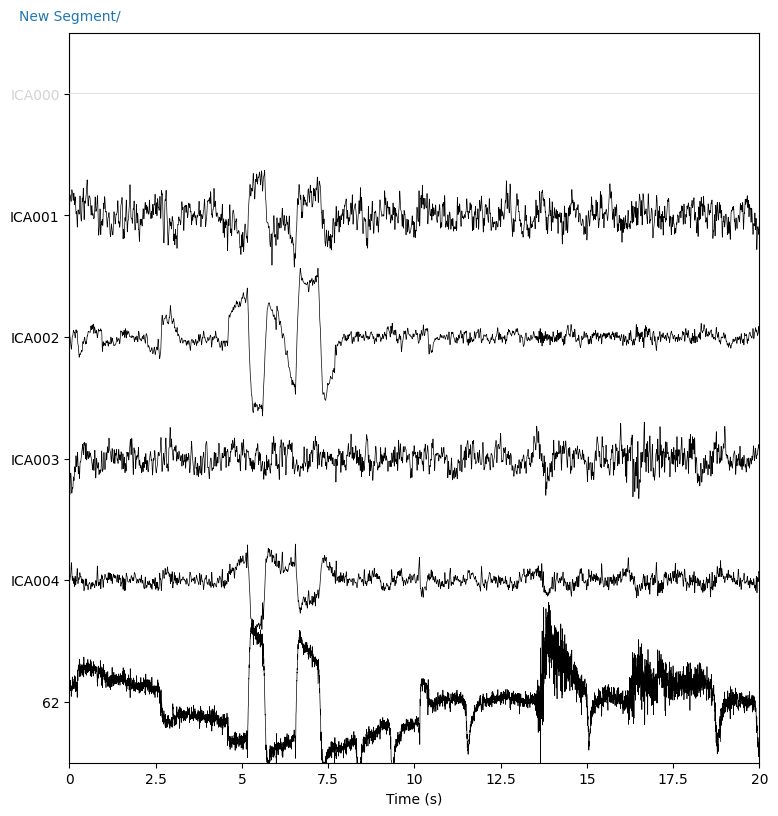

In [18]:
ica.plot_sources(raw, show_scrollbars=False);


In [20]:
# Epoch data from 300ms before stimulus to 700ms after
events, event_id = mne.events_from_annotations(raw)
print(events)
print(events,event_id)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Response/R  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S121', 'Stimulus/S122', 'Stimulus/S123', 'Stimulus/S131', 'Stimulus/S132', 'Stimulus/S133', 'Stimulus/S141', 'Stimulus/S142', 'Stimulus/S143', 'Stimulus/S151', 'Stimulus/S152', 'Stimulus/S153', 'Stimulus/S161', 'Stimulus/S162', 'Stimulus/S163', 'Stimulus/S171', 'Stimulus/S172', 'Stimulus/S173', 'Stimulus/S181', 'Stimulus/S182', 'Stimulus/S183', 'Stimulus/S211', 'Stimulus/S212', 'Stimulus/S213', 'Stimulus/S221', 'Stimulus/S222', 'Stimulus/S223', 'Stimulus/S231', 'Stimulus/S232', 'Stimulus/S233', 'Stimulus/S241', 'Stimulus/S242', 'Stimulus/S243']
[[      0       0   99999]
 [  13754       0    1008]
 [  14805       0     153]
 ...
 [2673239       0     111]
 [2673897       0     121]
 [2674646       0     131]]
[[      0       0   99999]
 [  13754       0    1008]
 [

### Process Event Data
Event data in codes (like '122'/'131'/'113') being converted to labels

In [21]:
target_mapping = {'1': 'not_target', '2': 'target'}
item_mapping = {'1': 'cow', '2': 'bear', '3': 'lion', '4': 'ape', '5': 'ax', '6': 'scissors', '7': 'comb', '8': 'pen'}
modality_mapping = {'1': 'written', '2': 'picture', '3': 'spoken'}

# Label the events
def relabel_event_id(event_id):
    event_id = str(event_id)

    if len(event_id) == 3:
        target = target_mapping[event_id[0]]
        if target == 'not_target':
            item = item_mapping[event_id[1]]
            category = 'animal' if int(event_id[1]) < 5 else 'tool'
        else:
            item= "unknown"
            category = "unknown"
        if 0 < int(event_id[2]) < 4:
            modality = modality_mapping[event_id[2]]
        else:
            modality = "error"
            
        label = f"{target}/{category}/{item}/{modality}"

    elif event_id == '1008':
        label = 'response'

    elif event_id == '99999':
        label = 'experiment_start'
    
    else:
        label = event_id

    return label

C:\Users\benja\AppData\Local\Temp\ipykernel_24876\2780291319.py:11: RuntimeWarning: event 211 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_id);
C:\Users\benja\AppData\Local\Temp\ipykernel_24876\2780291319.py:11: RuntimeWarning: event 212 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_id);
C:\Users\benja\AppData\Local\Temp\ipykernel_24876\2780291319.py:11: RuntimeWarning: event 222 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_id);
C:\Users\benja\AppData\Local\Temp\ipykernel_24876\2780291319.py:11: RuntimeWarning: event 223 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_id);
C:\Users\benja\AppData\Local\Temp\ipykernel_24876\2780291319.py:

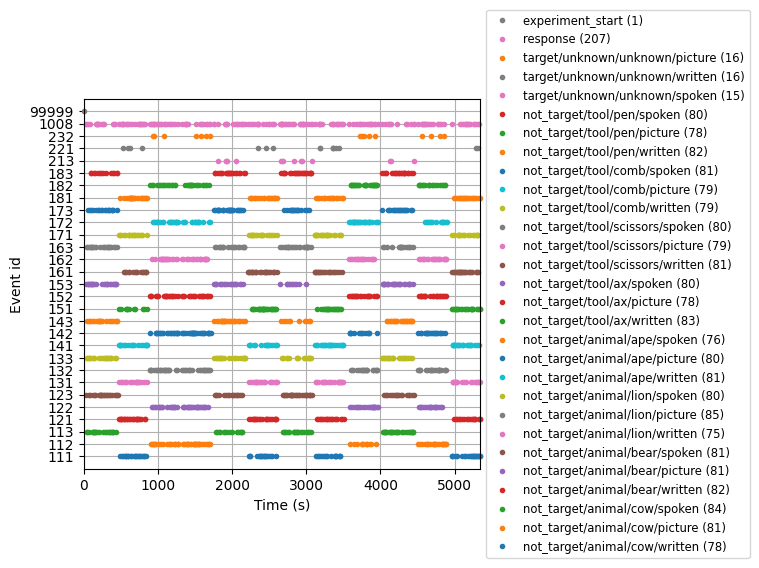

In [28]:
# Drop events with id 1, 11, 12, 13, 1004, 134
events = events[events[:,2] != 1]
events = events[events[:,2] != 11]
events = events[events[:,2] != 12]
events = events[events[:,2] != 13]
events = events[events[:,2] != 1004]
events = events[events[:,2] != 134]


event_id = {relabel_event_id(id): id for id in events[:,2]}
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_id);


#### Epoching data from 300ms before stimulus to 700ms after and rejecting epochs with amplitude variation > 150 uV

In [23]:
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.3, tmax=0.7, baseline=None, reject=dict(eeg=150e-6), preload=True)

Not setting metadata
2179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2179 events and 501 original time points ...
    Rejecting  epoch based on EEG : ['51']
    Rejecting  epoch based on EEG : ['18', '22', '33']
    Rejecting  epoch based on EEG : ['37', '51', '61']
    Rejecting  epoch based on EEG : ['49']
    Rejecting  epoch based on EEG : ['49', '50']
    Rejecting  epoch based on EEG : ['49', '50']
    Rejecting  epoch based on EEG : ['39']
    Rejecting  epoch based on EEG : ['54']
    Rejecting  epoch based on EEG : ['18', '22', '33', '47', '48']
    Rejecting  epoch based on EEG : ['51', '54']
    Rejecting  epoch based on EEG : ['44']
    Rejecting  epoch based on EEG : ['55']
    Rejecting  epoch based on EEG : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',

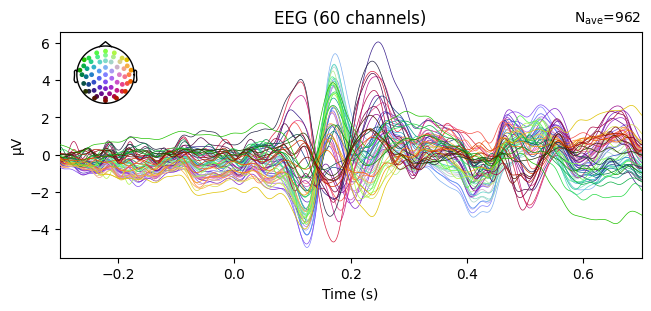

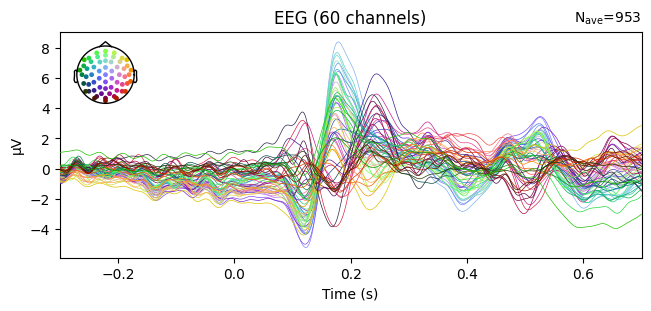

In [24]:
epochs['animal'].average().plot();
epochs['tool'].average().plot();

In [32]:
epochs

Number of events,2164
Events,experiment_start: 0not_target/animal/ape/picture: 80not_target/animal/ape/spoken: 75not_target/animal/ape/written: 80not_target/animal/bear/picture: 81not_target/animal/bear/spoken: 81not_target/animal/bear/written: 82not_target/animal/cow/picture: 81not_target/animal/cow/spoken: 84not_target/animal/cow/written: 78not_target/animal/lion/picture: 85not_target/animal/lion/spoken: 80not_target/animal/lion/written: 75not_target/tool/ax/picture: 78not_target/tool/ax/spoken: 80not_target/tool/ax/written: 83not_target/tool/comb/picture: 78not_target/tool/comb/spoken: 79not_target/tool/comb/written: 78not_target/tool/pen/picture: 78not_target/tool/pen/spoken: 79not_target/tool/pen/written: 81not_target/tool/scissors/picture: 79not_target/tool/scissors/spoken: 79not_target/tool/scissors/written: 81response: 202target/unknown/unknown/picture: 16target/unknown/unknown/spoken: 15target/unknown/unknown/written: 16
Time range,-0.300 – 0.700 s
Baseline,off
